# Resonant cavity - Discussion

In [1]:
# Temporary 'hack' for working directory not coinciding with file directory
import os
os.chdir('/home/fenics/shared/examples/resonant_cavity')

%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
cm = matplotlib.cm.get_cmap('inferno')

import fenics as fen
import mshr
from two_dimensional_cavity import TwoDimensionalCavity
from rectangular_cavity import RectangularCavity

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

## Rectangular cavity

In [3]:
Lx, Ly = 5.0, 1.0
Nx, Ny = 101, 21
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
RC = RectangularCavity(Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, g_N=g_N)
RC.setup()
#RC.plot_g_N()

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

### Full cavity

/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


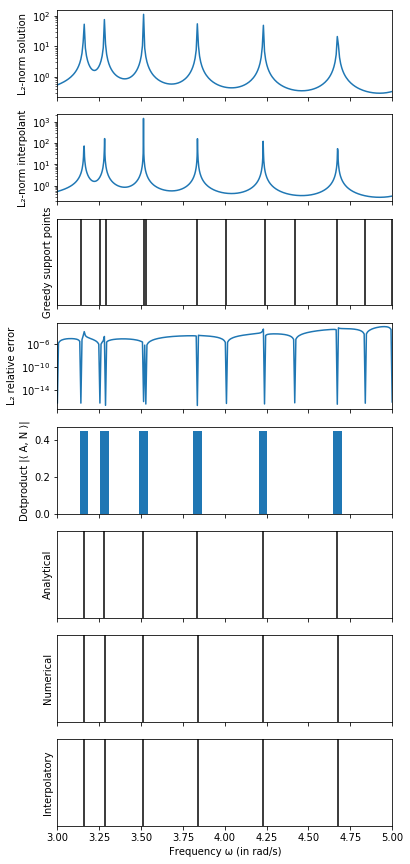

In [4]:
fig, ax = plt.subplots(8, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas, solver='fenics')
solution = RC.save_solution()
VS = VectorSpaceL2(RC)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Analytical')
helpers.plot_lines(ax[5], RC.get_analytical_eigenfrequencies(a, b))

ax[6].set_ylabel('Numerical')
helpers.plot_lines(ax[6], eigfreqs)

ax[7].set_ylabel('Interpolatory')
helpers.plot_lines(ax[7], MRI.get_interpolatory_eigenfrequencies(only_real=True))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

#### Progression of relative error in greedy MRI

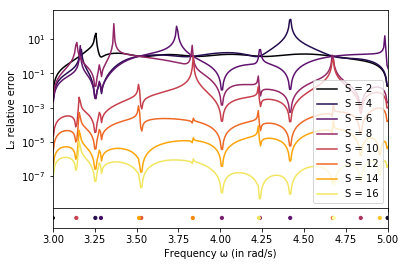

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'height_ratios': [10, 1]})

omegas = np.linspace(a, b, 300)
linspace = np.linspace(a-(b-a)/600, b+(b-a)/600, 301)
RC.solve(linspace)
u_linspace = RC.get_solution(trace=VS.get_trace())

MRI = MinimalRationalInterpolation(VS)
n_iter = 16
surrogate_history = MRI.compute_surrogate(RC, omegas, greedy=True, n_iter=n_iter, return_history=True)

for i in range(n_iter - 1)[::2]:
    RI = surrogate_history[i]
    helpers.plot_surrogate_error_norms(ax[0], RC, MRI, VS, u_linspace, linspace, RI,
        label='S = {}'.format(i+2), color=cm(i/(n_iter-1)))
nodes = MRI.u_ring.get_nodes()
ax[1].scatter(nodes, np.zeros_like(nodes), s=10, c=cm(np.arange(len(nodes))/(n_iter-1)), zorder=-n_iter)
ax[0].set_ylabel('L\u2082 relative error')
ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[1].set_xlim(a, b)
ax[1].set_yticks([])
ax[0].legend()
plt.subplots_adjust(wspace=0, hspace=0)

#### Analyzing symmetry of eigenmodes

/home/fenics/shared/examples/resonant_cavity/rectangular_cavity.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  u_func.vector()[:] = u_vec


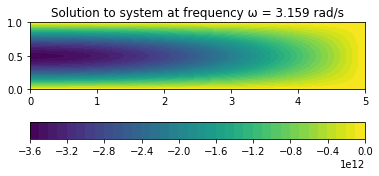

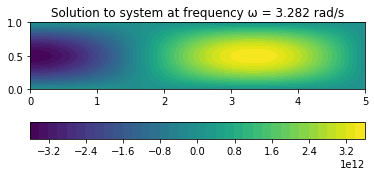

In [6]:
RC.solve(eigfreqs[:2])
RC.plot_solution()

### Inlet of cavity

Relative range of singular values is 1.50e+13.
Relative range of singular values is 2.79e+13.
Relative range of singular values is 3.01e+13.
Relative range of singular values is 3.09e+13.
Relative range of singular values is 3.10e+13.
Relative range of singular values is 3.32e+13.
Relative range of singular values is 3.42e+13.
Relative range of singular values is 3.85e+13.
Relative range of singular values is 3.83e+13.
Relative range of singular values is 3.96e+13.
Relative range of singular values is 4.13e+13.
Relative range of singular values is 4.26e+13.
Relative range of singular values is 1.08e+14.
Relative range of singular values is 1.55e+14.
Relative range of singular values is 1.66e+14.
Relative range of singular values is 1.75e+14.
Relative range of singular values is 1.79e+13.
Relative range of singular values is 1.67e+13.


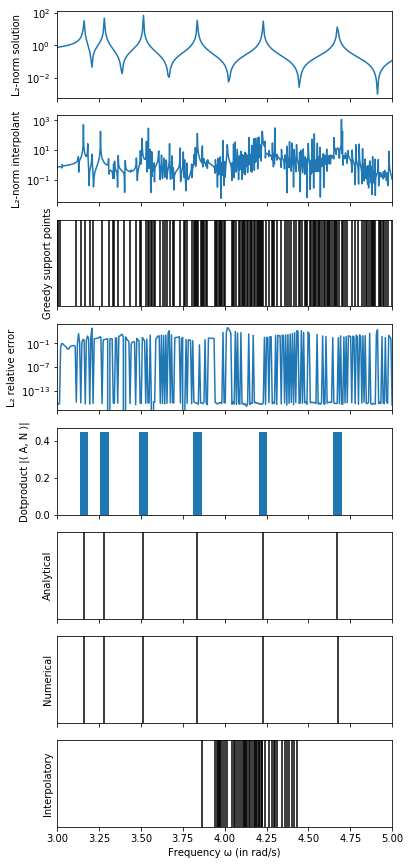

In [7]:
fig, ax = plt.subplots(8, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
solution = RC.save_solution(trace=inlet())
VS = VectorSpaceL2(RC, inlet())
MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-1)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Analytical')
helpers.plot_lines(ax[5], RC.get_analytical_eigenfrequencies(a, b))

ax[6].set_ylabel('Numerical')
helpers.plot_lines(ax[6], eigfreqs)

ax[7].set_ylabel('Interpolatory')
helpers.plot_lines(ax[7], MRI.get_interpolatory_eigenfrequencies(only_real=True))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

Standard deviation of trace-quotient: 1.20e-15


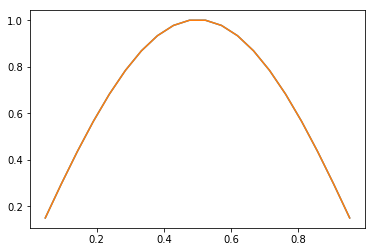

In [8]:
fig, ax = plt.subplots(1, 1)
RC.solve(eigfreqs)
x = RC.get_solution(trace=inlet())
all_coords = RC.V.tabulate_dof_coordinates()
trace_coords = np.array([x for x in all_coords if inlet().inside(x, 'on_boundary')])
ax.plot(trace_coords[:, 1], np.abs(x[0])/np.max(np.abs(x[0])))
ax.plot(trace_coords[:, 1], np.abs(x[1])/np.max(np.abs(x[1])))
print('Standard deviation of trace-quotient: {:.2e}'.format(np.std(x[1] / x[0])))

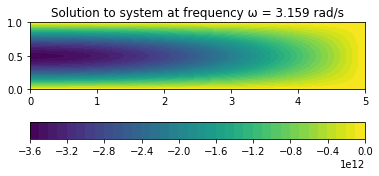

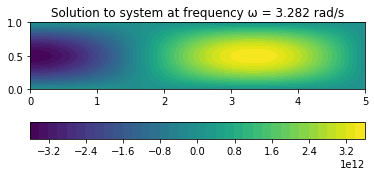

In [9]:
RC.solve(eigfreqs[:2])
RC.plot_solution()

## Rectangular cavity with cubby (breaking symmetry)

In [10]:
Lx, Ly = 5.0, 1.0

domain = mshr.Rectangle(fen.Point(0.0, 0.0), fen.Point(Lx, Ly)) \
       + mshr.Rectangle(fen.Point(Lx*0.5, Ly), fen.Point(Lx*0.75, Ly*1.25))
mesh = mshr.generate_mesh(domain, 100)

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
TDC = TwoDimensionalCavity(mesh=mesh, B_N=inlet, g_N=g_N)
TDC.setup()

Relative range of singular values is 4.84e+13.


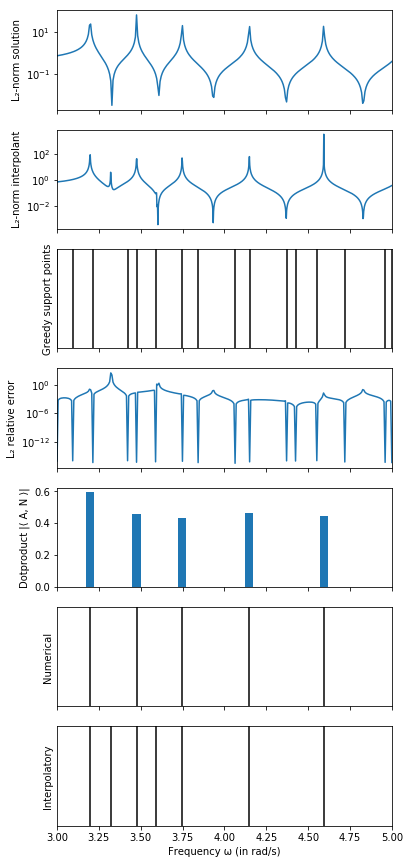

In [11]:
fig, ax = plt.subplots(7, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
TDC.solve(omegas)
solution = TDC.save_solution(trace=inlet())
VS = VectorSpaceL2(TDC, inlet())
MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(TDC, omegas=omegas, greedy=True, tol=7.5e-1)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], solution, VS)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.u_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], solution, MRI, VS)

eigfreqs, eigvecs = TDC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(TDC.insert_boundary_values(eigvec), TDC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Numerical')
helpers.plot_lines(ax[5], eigfreqs)

ax[6].set_ylabel('Interpolatory')
helpers.plot_lines(ax[6], MRI.get_interpolatory_eigenfrequencies(only_real=True))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

Stabdard deviation of trace-quotient: 1.74e-06


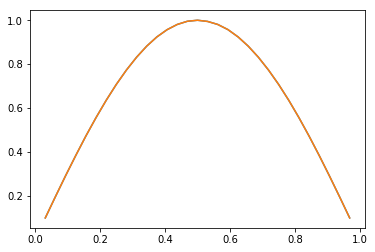

In [12]:
fig, ax = plt.subplots(1, 1)
TDC.solve(eigfreqs)
x = TDC.get_solution(trace=inlet())
all_coords = TDC.V.tabulate_dof_coordinates()
trace_coords = np.array([x for x in all_coords if inlet().inside(x, 'on_boundary')])
idx_sorted = sorted(range(len(trace_coords)), key=trace_coords[:, 1].__getitem__)
x0_sorted = [x[0, i] for i in idx_sorted]
x1_sorted = [x[1, i] for i in idx_sorted]
ax.plot(trace_coords[idx_sorted, 1], np.abs(x0_sorted)/np.max(np.abs(x[0])))
ax.plot(trace_coords[idx_sorted, 1], np.abs(x1_sorted)/np.max(np.abs(x[1])))
print('Stabdard deviation of trace-quotient: {:.2e}'.format(np.std(x[1] / x[0])))

## Compare eigensolver to rational interpolation

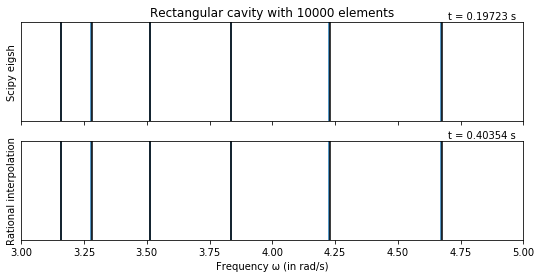

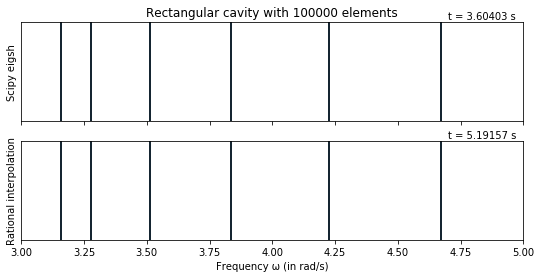

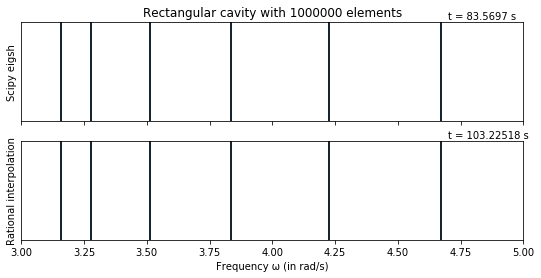

In [ ]:
Lx, Ly = 5.0, 1.0
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)

a = 3
b = 5
omegas = np.linspace(a, b, 100)

for N in np.logspace(4, 6, 3, dtype=int):
    RC = RectangularCavity(Lx=Lx, Ly=Ly, Nx=int(pow(N*Lx/(Lx+Ly), 0.5)), Ny=int(pow(N*Ly/(Lx+Ly), 0.5)), g_N=g_N)
    RC.setup()
    #RC.solve(omegas)
    VS = VectorSpaceL2(RC)
    #snapshots = RC.get_solution(tonumpy=True, trace=VS.get_trace())
    fig, ax = plt.subplots(2, 1, figsize=(9, 4), sharex=True)
    helpers.plot_lines(ax[0], RC.get_analytical_eigenfrequencies(a, b), color='C0')
    t0 = time.time()
    helpers.plot_lines(ax[0], RC.get_numerical_eigenfrequencies(a, b))
    t_FE = time.time() - t0
    helpers.plot_lines(ax[1], RC.get_analytical_eigenfrequencies(a, b), color='C0')
    t0 = time.time()
    MRI = MinimalRationalInterpolation(VS)
    MRI.compute_surrogate(RC, omegas=omegas, greedy=True, tol=1e-2, solver='fenics') 
    helpers.plot_lines(ax[1], MRI.get_interpolatory_eigenfrequencies(only_real=True))
    t_RI = time.time() - t0
    ax[0].set_title(f'Rectangular cavity with {N} elements')
    ax[0].set_ylabel('Scipy eigsh')
    ax[0].text(0.85, 1.03, f't = {round(t_FE, 5)} s', transform=ax[0].transAxes)
    ax[0].set_yticks([])
    ax[1].set_ylabel('Rational interpolation')
    ax[0].text(0.85, 1.03, f't = {round(t_RI, 5)} s', transform=ax[1].transAxes)
    ax[1].set_yticks([])
    ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
    ax[1].set_xlim(a, b)
    plt.show()